# [Mountain Car](https://gymnasium.farama.org/environments/classic_control/mountain_car/)

山地车env具有一个连续的observation （shape (2,),0表示车辆当前的x值,1表示车辆当前的速度）

action space = 3 （0表示向左加速，1表示不加速，2表示向右加速）

reward：The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep.

Mountain Car环境因为state不再是离散环境，直接使用Qlearning或者使用SARSA等tabular solution method不是很合适，但是它却是一个非常不错的用来测试Value Function Approximation的环境

In [1]:
import gymnasium as gym
import numpy as np
from utils import feature, Q_value, Q, epsilon_greedy_action,plot_training_rewards,moving_average
gamma = 0.99
alpha = 0.01
n_episodes = 10000
epsilon = 0.1  # ε-greedy 探索概率

env = gym.make("MountainCar-v0")
n_actions = env.action_space.n

## Part one
使用VFA+MC来尝试完成任务

In [2]:
def train_MC(n_episodes = 10000,gamma = 0.99,alpha = 0.01, epsilon = 0.1):
    env = gym.make("MountainCar-v0")
    env._max_episode_steps = 1000 # 尝试增大最大步数，看能否解决问题

    n_features = len(feature(env.reset()[0]))
    W = np.zeros((n_actions, n_features))
    total_reward = []
    for episode in range(n_episodes):
        trajectory = []
        state, _ = env.reset()
        done = False

        while not done:
            action = epsilon_greedy_action(state,W,epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            trajectory.append((state, action, reward))
            done = terminated or truncated
            state = next_state

        G = 0
        returns = []
        for (_, _, reward) in reversed(trajectory):
            G = reward + gamma * G
            returns.insert(0, G)
        
        total_reward.append(sum(r for (_, _, r) in trajectory))

        visited = set()
        for t, (state, action, _) in enumerate(trajectory):
            key = (tuple(state), action)
            if key not in visited:
                visited.add(key)
                G_t = returns[t]
                q_hat = Q(state, action,W)
                phi = feature(state)
                W[action] += alpha * (G_t - q_hat) * phi

        if (episode + 1) % 500 == 0:
            print(f"Episode {episode + 1}/{n_episodes}, reward = {total_reward[-1]}")
    env.close()

    return W, total_reward

In [3]:
W_mc, total_reward = train_MC()
plot_training_rewards(total_reward)

KeyboardInterrupt: 

个人感觉使用MC不能训练出好的可以解决问题的模型(maybe)，以后会再尝试看有无好的解决方案

## part two
测试TD（0）算法+VFA在这个问题下的表现

In [ ]:
def train_SARSA(n_episodes = 40000,gamma = 0.99, alpha = 0.01, epsilon = 0.1):
    env = gym.make("MountainCar-v0")

    env._max_episode_steps = 1000
    n_features = len(feature(env.reset()[0]))
    W = np.zeros((n_actions, n_features))
    total_reward = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        action = epsilon_greedy_action(state,W,epsilon)
        done = False
        sum_reward = 0

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = epsilon_greedy_action(next_state,W,epsilon)
            done = terminated or truncated

            sum_reward += reward
            
            q_hat = Q(state, action,W)
            if done:
                target = reward
            else:
                target = reward + gamma * Q(next_state, next_action,W)
            phi = feature(state)
            W[action] += alpha * (target - q_hat) * phi

            state,action = next_state,next_action
        
        total_reward.append(sum_reward)

        if (episode + 1) % 500 == 0:
            print(f"Episode {episode + 1}/{n_episodes},reward = {sum_reward}")
    env.close()
    return W, total_reward

In [ ]:
W, total_reward = train_SARSA()
plot_training_rewards(total_reward)

不出所料，线形近似下不管是SARSA还是MC都无法解决Mountain Car问题，这个事情的原因是因为Mountain Car并非一个线形可分问题，故使用单纯的线性近似是无法解决这个非线性动力学问题的（这个解释我问的gpt，感觉有点道理）

## Part Three
尝试使用[DQN](https://arxiv.org/abs/1509.06461)来解决Mountain Car

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import collections
from tqdm import tqdm
import random

In [5]:
# 定义 Replay Buffer
# 改编自 https://github.com/boyu-ai/Hands-on-RL/blob/main/rl_utils.py
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), actions, rewards, np.array(next_states), dones

    def size(self):
        return len(self.buffer)

In [6]:
# 定义 Q_net
class Q_net(torch.nn.Module):
    def __init__(self, state_dim,hidden_dim,action_dim):
        super(Q_net, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim,action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [7]:
# DQN算法的具体实现
class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, lr,gamma,epsilon,target_update, device = torch.device("cpu")):
        self.action_dim = action_dim
        self.q_net = Q_net(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Q_net(state_dim, hidden_dim, self.action_dim).to(device)
        
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)

        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update #目标网络更新频率
        self.device = device
        self.count = 0

    # 动作函数基于 epsilon-greedy策略
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype = torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        
        return action

    # update函数
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype = torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1,1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards']).view(-1,1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype = torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1,1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1,1) 
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

In [8]:
lr = 2e-3
num_episodes = 2000
hidden_dim = 256
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 400
batch_size = 32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'MountainCar-v0'
env = gym.make(env_name)
random.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update,device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes/10),desc = 'Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state,_ = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode+1)%100 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-50:])
                })

            pbar.update(1)


Iteration 0:   0%|          | 0/200 [00:00<?, ?it/s]/var/folders/1b/8dtqs35938jc7s9qlpl800yc0000gn/T/ipykernel_10493/3005780587.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  state = torch.tensor([state], dtype = torch.float).to(self.device)
Iteration 9: 100%|██████████| 200/200 [00:15<00:00, 12.81it/s, episode=2000, return=-133.460]


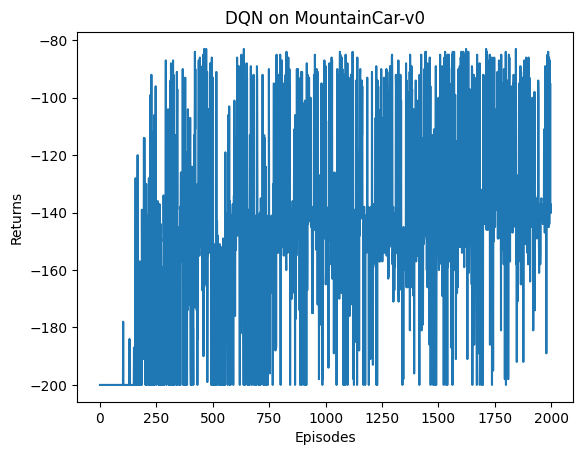

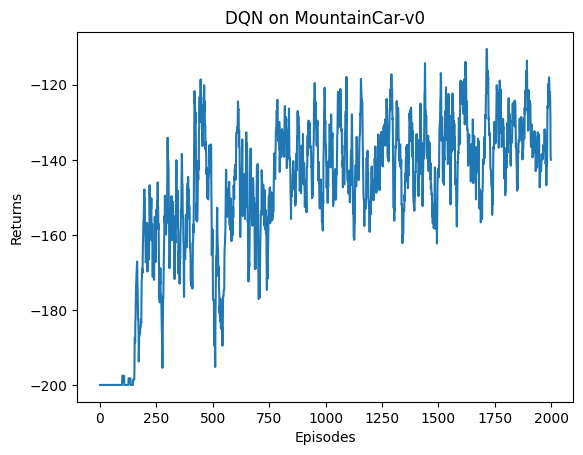

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [9]:
# test agent
def test_agent(agent, n_episodes=10):
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0
    env = gym.make('MountainCar-v0',render_mode='human')
    returns = []
    successes = 0
    for ep in range(n_episodes):
        state, _ = env.reset()
        done = False
        ep_return = 0.0
        reached = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_return += reward
            # 判断是否到达目标（MountainCar 目标 x >= 0.5）
            if next_state[0] >= 0.5:
                reached = True
            state = next_state
        returns.append(ep_return)
        if reached:
            successes += 1

    agent.epsilon = old_epsilon

    avg_return = np.mean(returns)
    success_rate = successes / n_episodes
    print(f"Test episodes={n_episodes}, avg_return={avg_return:.2f}, success_rate={success_rate:.2f}")
    return returns, avg_return, success_rate

In [ ]:
test_agent(agent)

/Users/crazybread/miniconda3/envs/rl/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Test episodes=10, avg_return=-119.00, success_rate=1.00


([-140.0, -103.0, -92.0, -91.0, -94.0, -159.0, -84.0, -144.0, -141.0, -142.0],
 np.float64(-119.0),
 1.0)

: 